# Test out standardized ADCIRC, SELFE and FVCOM  datasets with pyugrid, IRIS and Cartopy

The datasets being accessed here are NetCDF files from ADCIRC, SELFE and FVCOM, with attributes added or modified virtually using NcML to meet the [UGRID conevntions standard for unstructured grid models](https://github.com/ugrid-conventions/ugrid-conventions/blob/v0.9.0/ugrid-conventions.md). 

This example was developed for the Integrated Ocean Observing System (IOOS) Coastal and Ocean Modeling Testbed. 

You can quickly and easily [set up the IOOS Anaconda python environment that can run this notebook](https://github.com/ioos/conda-recipes/wiki).

In [1]:
%matplotlib inline
from __future__ import (absolute_import, division, print_function)
import numpy as np
import matplotlib.tri as tri
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
import cartopy.crs as ccrs
import iris
iris.FUTURE.netcdf_promote = True
import pyugrid

In [3]:
# specify UGRID compliant OPeNDAP Data URL

#ADCIRC
#url = 'http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/UND_ADCIRC/Hurricane_Rita_2D_final_run_without_waves'

#FVCOM
#url = 'http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/USF_FVCOM/Hurricane_Rita_2D_final_run_without_waves'

#SELFE
#url = 'http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/VIMS_SELFE/Hurricane_Rita_2D_final_run_without_waves'

#MWRA FVCOM
url = 'http://www.smast.umassd.edu:8080/thredds/dodsC/fvcom/mwra/fvcom'
# set parameters
bbox = bbox = [-71.15, -69.8, 41.7, 42.7]  # set the bounding box [lon_min, lon_max, lat_min, lat_max]
var = 'sea_water_potential_temperature'     # standard_name (or long_name, if no standard_name)
levs = np.arange(3.,9.,.2)                # set the contour levels
start = dt.datetime(2005, 9, 24, 5, 0, 0)  # time in UTC
#start = dt.datetime.utcnow() + dt.timedelta(hours=6)
klev = 0    # level 0 is surface, -1 is bottom

In [4]:
cube = iris.load_cube(url,var)

C:\Anaconda64\envs\ioos3\lib\site-packages\iris\fileformats\cf.py:552: UserWarning: Missing CF-netCDF formula term variable u'depth', referenced by netCDF variable u'siglev'
  warnings.warn(message % (variable_name, nc_var_name))
C:\Anaconda64\envs\ioos3\lib\site-packages\iris\fileformats\cf.py:1006: UserWarning: Ignoring variable u'siglay' referenced by variable u'v': Dimensions (u'siglay', u'node') do not span (u'time', u'siglay', u'nele')
  warnings.warn(msg)
C:\Anaconda64\envs\ioos3\lib\site-packages\iris\fileformats\cf.py:1006: UserWarning: Ignoring variable u'siglay' referenced by variable u'ww': Dimensions (u'siglay', u'node') do not span (u'time', u'siglay', u'nele')
  warnings.warn(msg)
C:\Anaconda64\envs\ioos3\lib\site-packages\iris\fileformats\cf.py:1006: UserWarning: Ignoring variable u'siglay' referenced by variable u'u': Dimensions (u'siglay', u'node') do not span (u'time', u'siglay', u'nele')
  warnings.warn(msg)
C:\Anaconda64\envs\ioos3\lib\site-packages\iris\fileformat

In [5]:
print(cube)

sea_water_potential_temperature             (time: 131611; -- : 30; -- : 5472)
     Dimension coordinates:
          time                                             x            -        -
     Auxiliary coordinates:
          sea_surface_height_above_geoid                   x            -        x
          ocean_sigma_coordinate                           -            x        x
          latitude                                         -            -        x
          longitude                                        -            -        x
          sea_floor_depth_below_geoid                      -            -        x
     Derived coordinates:
          sea_surface_height_above_reference_ellipsoid     x            x        x
     Attributes:
          Conventions: CF-1.0, UGRID-0.9
          CoordinateProjection: init=nad83:1802
          CoordinateSystem: Cartesian
          GroundWater_Forcing: FVCOM variable GroundWater forcing:
FILE NAME:gom_gwater_forcing.nc
SOURCE:FVCOM...

In [6]:
ug = pyugrid.UGrid.from_ncfile(url)

# What's in there?
#print("There are %i nodes"%ug.nodes.shape[0])
#print("There are %i edges"%ug.edges.shape[0])
#print("There are %i faces"%ug.faces.shape[0])

In [7]:
cube.mesh = ug
cube.mesh_dimension = 1  # (0:time,1:node)

In [8]:
lon = cube.mesh.nodes[:,0]
lat = cube.mesh.nodes[:,1]
nv = cube.mesh.faces

In [9]:
triang = tri.Triangulation(lon,lat,triangles=nv)

In [10]:
tvar = cube.coord('time')
itime = tvar.nearest_neighbour_index(tvar.units.date2num(start))

In [11]:
zcube = cube[itime,klev]

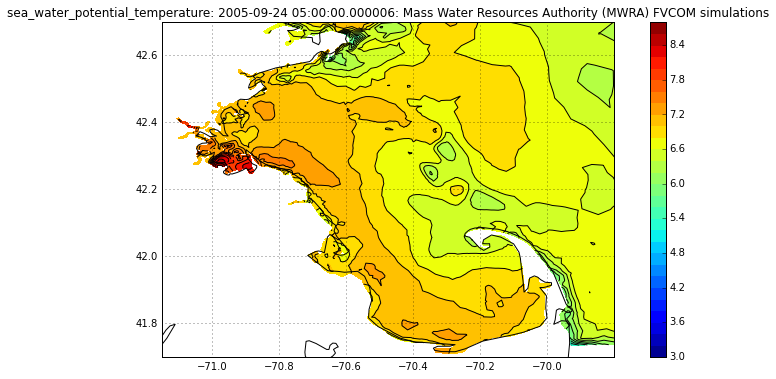

In [12]:
plt.figure(figsize=(16,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(bbox)
ax.coastlines(resolution='10m')
plt.tricontourf(triang, zcube.data, levels=levs)
plt.colorbar(fraction=0.046, pad=0.04)
plt.tricontour(triang, zcube.data, colors='k',levels=levs)
tstr = tvar.units.num2date(tvar.points[itime])
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.title('%s: %s: %s' % (var,tstr,zcube.attributes['title']));

In [13]:
ucube = iris.load_raw(url,'eastward_sea_water_velocity')[0]
vcube = iris.load_raw(url,'northward_sea_water_velocity')[0]

In [14]:
# layer to plot (0 is surface, -1 is bottom)
klev = 0

u = ucube[itime,klev,:].data
v = vcube[itime,klev,:].data

In [15]:
lonc = cube.mesh.face_coordinates[:,0]
latc = cube.mesh.face_coordinates[:,1]

In [16]:
subsample = 5
# find velocity points in bounding box
ind = np.argwhere((lonc >= bbox[0]) & (lonc <= bbox[1]) & (latc >= bbox[2]) & (latc <= bbox[3]))
np.random.shuffle(ind)
Nvec = int(len(ind) / subsample)
idv = ind[:Nvec]

In [17]:
import mplleaflet
fig = plt.figure(figsize=(10,5))
vscale = 30  # smaller makes arrows bigger
q = plt.quiver(lonc[idv], latc[idv], u[idv], v[idv], scale=vscale, color='white')
plt.axis(bbox) 
#q.set_title('{}'.format(glocals[k]))
mplleaflet.display(fig=fig, tiles='esri_aerial')